In [ ]:
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes, labels = [], []
   
    for obj in root.findall("object"):
        label = obj.find("name").text
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)
       
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)
   
    return boxes, labels


def load_dataset(folder_path):
    images, labels = [], []
   
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder_path, filename)
            xml_path = os.path.join(folder_path, filename.replace(".jpg", ".xml"))

            if os.path.exists(xml_path):
                img = cv2.imread(img_path)
                boxes, label_list = parse_xml(xml_path)

                for box, label in zip(boxes, label_list):
                    # Crop the image using the bounding box
                    xmin, ymin, xmax, ymax = box
                    crop = img[ymin:ymax, xmin:xmax]
                    if crop.size == 0:
                        continue
                    images.append(crop)
                    labels.append(label)
            else:
                print(f"Warning: XML annotation missing for {filename}")

    return images, labels


dataset_path = "C:/Users/admin/Downloads/CNN_TEST/Object detection dataset/train/train"
 
images, all_labels = load_dataset(dataset_path)


assert len(images) == len(all_labels), "Mismatch between images and labels!"
ormat
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(all_labels)
er
joblib.dump(label_encoder, 'label_encoder.pkl')

num_classes = len(np.unique(encoded_labels))
y = np.zeros((len(encoded_labels), num_classes))
for i, label in enumerate(encoded_labels):
    y[i, label] = 1

X = np.array([cv2.resize(img, (224, 224)) / 255.0 for img in images])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")


datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.15,
    horizontal_flip=True
)
datagen.fit(X_train)


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=5, validation_data=(X_test, y_test))


model.save('classification_model.keras')

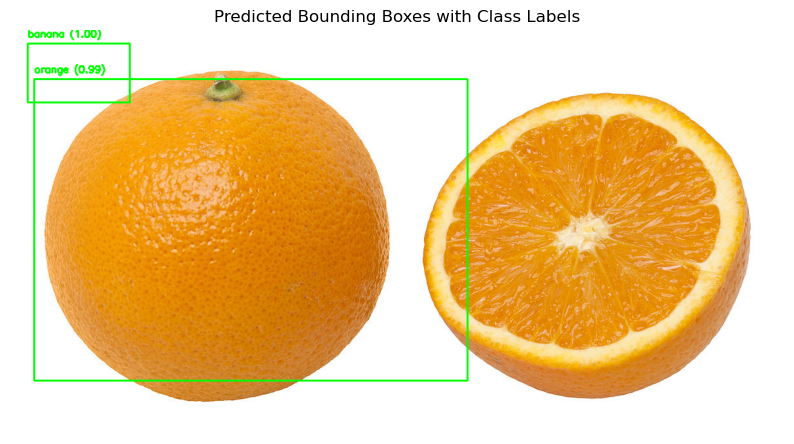

In [ ]:

import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
import joblib
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt


data_dir = "C:/Users/admin/Downloads/CNN_TEST/Object detection dataset/train/train"
max_objects = 5
img_size = (64, 64)  
cnn_img_size = (224, 224)  
conf_threshold = 0.1


def parse_xml(xml_file, img_shape):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text) / img_shape[1]
        ymin = float(bbox.find('ymin').text) / img_shape[0]
        xmax = float(bbox.find('xmax').text) / img_shape[1]
        ymax = float(bbox.find('ymax').text) / img_shape[0]
        boxes.append([xmin, ymin, xmax, ymax])
    return boxes

def extract_pixel_features(img, img_size=(64, 64)):
    if img is None or img.size == 0:
        raise ValueError("Invalid image provided to extract_pixel_features")
    img = cv2.resize(img, img_size)
    img = img / 255.0
    features = img.flatten()
    print(f"Pixel features shape: {features.shape}")
    return features

def load_dataset(data_dir, img_size=(64, 64)):
    features = []
    all_boxes = []
    for img_file in os.listdir(data_dir):
        if not img_file.endswith('.jpg'):
            continue
        img_path = os.path.join(data_dir, img_file)
        xml_path = os.path.join(data_dir, img_file.replace('.jpg', '.xml'))
        if not os.path.exists(xml_path):
            print(f"Warning: XML file not found for {img_file}")
            continue
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not load image {img_path}")
            continue
        original_shape = img.shape[:2]
        pixel_features = extract_pixel_features(img, img_size)
        boxes = parse_xml(xml_path, original_shape)
        boxes = boxes[:max_objects] + [[0, 0, 0, 0]] * (max_objects - len(boxes))
        boxes_flat = np.array(boxes).flatten()
        features.append(pixel_features)
        all_boxes.append(boxes_flat)
    return np.array(features), np.array(all_boxes)


def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    iou = intersection / (union + 1e-6) if union > 0 else 0.0
    return iou

def evaluate_iou(y_pred, y_true, max_objects=5):
    ious = []
    for pred, true in zip(y_pred, y_true):
        pred_boxes = pred.reshape(max_objects, 4)
        true_boxes = true.reshape(max_objects, 4)
        img_ious = []
        for i in range(max_objects):
            if np.sum(true_boxes[i]) == 0:
                continue
            best_iou = 0.0
            for j in range(max_objects):
                if np.sum(pred_boxes[j]) < conf_threshold:
                    continue
                iou = compute_iou(pred_boxes[j], true_boxes[i])
                best_iou = max(best_iou, iou)
            img_ious.append(best_iou)
        if img_ious:
            ious.append(np.mean(img_ious))
    return np.mean(ious) if ious else 0.0


features, boxes = load_dataset(data_dir, img_size)
if len(features) == 0:
    raise ValueError("No images loaded. Check data_dir and file paths.")
print(f"Loaded {len(features)} images with features shape: {features.shape}")


feature_scaler = StandardScaler()
boxes_scaler = StandardScaler()
train_features, val_features, train_boxes, val_boxes = train_test_split(
    features, boxes, test_size=0.2, random_state=42
)
train_features = feature_scaler.fit_transform(train_features)
val_features = feature_scaler.transform(val_features)
train_boxes = boxes_scaler.fit_transform(train_boxes)
val_boxes = boxes_scaler.transform(val_boxes)


model_svr = MultiOutputRegressor(SVR(kernel='rbf', C=1.0, epsilon=0.1), n_jobs=-1)
model_svr.fit(train_features, train_boxes)


val_predictions = model_svr.predict(val_features)
val_predictions = boxes_scaler.inverse_transform(val_predictions)  
val_boxes = boxes_scaler.inverse_transform(val_boxes)  
val_iou = evaluate_iou(val_predictions, val_boxes, max_objects)
print(f"Validation IoU: {val_iou:.6f}")


joblib.dump(feature_scaler, 'feature_scaler.pkl')
joblib.dump(boxes_scaler, 'boxes_scaler.pkl')

cnn_model = load_model('classification_model.keras')
label_encoder = joblib.load('label_encoder.pkl')


def predict_classify_and_visualize(image_path, svr_model, cnn_model, label_encoder, feature_scaler, boxes_scaler, img_size=(64, 64), cnn_img_size=(224, 224), conf_threshold=0.1):
    
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image {image_path}")
        return
    original_shape = img.shape[:2]
    img_display = img.copy()  
    
    
    pixel_features = extract_pixel_features(img, img_size)
    pixel_features = feature_scaler.transform([pixel_features])
    
    
    box_preds = svr_model.predict(pixel_features)[0]
    box_preds = boxes_scaler.inverse_transform([box_preds])[0]  
    box_preds = box_preds.reshape(max_objects, 4)
    
    
    for i, box in enumerate(box_preds):
        if np.sum(box) < conf_threshold:
            continue

        xmin = int(box[0] * original_shape[1])
        ymin = int(box[1] * original_shape[0])
        xmax = int(box[2] * original_shape[1])
        ymax = int(box[3] * original_shape[0])
        xmin, ymin = max(0, xmin), max(0, ymin)
        xmax, ymax = min(original_shape[1], xmax), min(original_shape[0], ymax)
        if xmax <= xmin or ymax <= ymin:
            continue
        
        crop = img[ymin:ymax, xmin:xmax]
        if crop.size == 0:
            continue
        
        crop = cv2.resize(crop, cnn_img_size)
        crop = crop / 255.0
        crop = np.expand_dims(crop, axis=0)
        
        class_probs = cnn_model.predict(crop, verbose=0)[0]
        class_idx = np.argmax(class_probs)
        class_label = label_encoder.inverse_transform([class_idx])[0]
        confidence = class_probs[class_idx]
        
        cv2.rectangle(img_display, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        label_text = f"{class_label} ({confidence:.2f})"
        cv2.putText(img_display, label_text, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    
    img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(img_display)
    plt.axis('off')
    plt.title('Predicted Bounding Boxes with Class Labels')
    plt.show()

# Example usage
new_image_path = "C:/Users/admin/Downloads/CNN_TEST/Object detection dataset/train/train/orange_7.jpg"
predict_classify_and_visualize(new_image_path, model_svr, cnn_model, label_encoder, feature_scaler, boxes_scaler, img_size, cnn_img_size, conf_threshold)


In [ ]:
new_image_path = "C:/Users/admin/Downloads/CNN_TEST/Object detection dataset/train/train/banana_74.jpg"  # Replace with your test image path
predict_classify_and_visualize(new_image_path, model_svr, cnn_model, label_encoder, feature_scaler, boxes_scaler, img_size, cnn_img_size, conf_threshold)